In [28]:
#!/usr/bin/python3

import numpy as np
from sys import argv
#import pyoma.browser.db as db
import pyoma.browser.models as mod
import zoo.wrappers.aligners.mafft as mafft
import zoo.wrappers.treebuilders.fasttree as fasttree
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Alphabet import IUPAC, SingleLetterAlphabet
from Bio.Seq import Seq, UnknownSeq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict

import pickle
    
from os import listdir
from os.path import isfile, join
from datetime import datetime

import concurrent.futures


import ast
# #  for development 
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt


datasets_address= "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/archive/"
oma_database_address = datasets_address + "OmaServer.h5"
hog_og_map_address = datasets_address + "hog_og_map.dic"
omaID_address = datasets_address+"oma-species.txt"
bird6ID_address = datasets_address+"info.tsv"


project_folder ="/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v4a/proteome/" 
# very small
#project_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v3a/ST/f4_100S/" 


## global variable
#project_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v3a/A/f7_2kA/" 

#project_folder = argv[1]


# PANPA.fa  PANPA.hogmap
# The species name of query is the name of the file; 
#  argv[2] 




In [ ]:

def parse_oma(oma_database_address, hog_og_map_address):
    
    ############### Parsing OMA db ####################
    ###################################################

    oma_db = db.Database(oma_database_address)

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- OMA data is parsed and its release name is:", oma_db.get_release_name())
    list_speices= [z.uniprot_species_code for z in oma_db.tax.genomes.values()] 
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- There are",len(list_speices),"species in the OMA database.")

    hog_OG_map = []
#     file = open(hog_og_map_address, "r")
#     contents = file.read()
#     hog_OG_map = ast.literal_eval(contents)
#     file.close()
#     current_time = datetime.now().strftime("%H:%M:%S")
#     print(current_time,"- The hog-og map is read from file with the length of ", len(hog_OG_map))
    
    
    return (oma_db, hog_OG_map, list_speices)


def parse_proteome(list_speices):
    
    ############### Parsing query proteome of species #######
    #########################################################

    project_files = listdir(project_folder)

    query_species_names = []
    for file in project_files:
        if file.split(".")[-1]=="fa":
            file_name_split = file.split(".")[:-1]
            query_species_names.append('.'.join(file_name_split))

    # we may assert existence of query_species_name+".fa/hogmap"
    query_prot_records_species = [ ]
    for query_species_name in query_species_names:
        query_prot_address = project_folder + query_species_name + ".fa" 
        query_prot_records = list(SeqIO.parse(query_prot_address, "fasta")) 
        query_prot_records_species.append(query_prot_records)
    query_species_num = len(query_species_names)    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- The are",str(query_species_num),"species in the project folder.")

    # for development
    query_species_num = len(query_species_names)
    for species_i in range(query_species_num):
        len_prot_record_i = len( query_prot_records_species[species_i] )
        species_name_i = query_species_names[species_i]
        #print(species_name_i,len_prot_record_i)
        if species_name_i in list_speices: 
            current_time = datetime.now().strftime("%H:%M:%S")
            print(current_time,"- the species",species_name_i," already exists in the oma database, remove it first")
            exit()

    return (query_species_names, query_prot_records_species)



# def parse_hogmap_omamer(query_species_names):

#     ################### Parsing omamer's output  ########
#     #####################################################

#     query_prot_names_species = []
#     query_hogids_species = []

#     for query_species_name in query_species_names:
#         omamer_output_address = project_folder + query_species_name + ".hogmap"     
#         omamer_output_file = open(omamer_output_address,'r');

#         query_prot_names= []
#         query_hogids= []

#         for line in omamer_output_file:
#             line_strip=line.strip()
#             if not line_strip.startswith('qs'):
#                 line_split= line_strip.split("\t")        
#                 query_prot_names.append(line_split[0])
#                 query_hogids.append(line_split[1])
#         #print("number of proteins in omamer output for ",query_species_name,"is",len(query_hogids)) # ,query_hogids
#         query_prot_names_species.append(query_prot_names)
#         query_hogids_species.append(query_hogids)    
        
#     current_time = datetime.now().strftime("%H:%M:%S")
#     print(current_time,"- There are ",len(query_prot_names_species)," in project folder.")
#     print(current_time,"- The first species",query_prot_names[0]," contains ",len(query_hogids_species[0])," proteins.")

    
#     return (query_prot_names_species, query_hogids_species)
    
    



def extract_unique_hog_pure(query_species_names,query_hogids_species, query_prot_names_species,query_prot_records_species):
    ###### Extracting unique HOG list and corresponding query proteins ########
    ###########################################################################

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- Extracting proteins mapped only once on a HOG is started")

    query_hogids_filtr_species = []
    query_prot_names_filtr_species = []
    query_prot_records_filtr_species = []

    repeated_hogid_num = 0
    
    query_species_num = len(query_species_names) 
    
    dic_hogs_list=[]  # a list of dictinaries 


    for species_i in range(query_species_num):

        query_hogids =  query_hogids_species[species_i]
        query_prot_names = query_prot_names_species[species_i]
        query_prot_records  = query_prot_records_species[species_i]
        
        dic_hogs = {}
        for prot_i in range(len(query_hogids)):
            query_hogid      = query_hogids[prot_i]
            query_prot_name  = query_prot_names[prot_i]
            query_prot_record= query_prot_records[prot_i]
            if  query_hogid  not in  dic_hogs:
                dic_hogs[query_hogid]=[(query_prot_name,query_prot_record)]
            else:
                repeated_hogid_num += 1 
                dic_hogs[query_hogid].append((query_prot_name,query_prot_record))
        dic_hogs_list.append(dic_hogs)

        
    for dic_hogs in dic_hogs_list: # each species
        
        query_prot_names_filtr = []
        query_prot_records_filtr = []

        hogid_list = list(dic_hogs.keys())
        for hogid in hogid_list:
            list_query_prot = dic_hogs[hogid]
            if len(list_query_prot)>1:
                del dic_hogs[hogid]
        #here dic_hogs is updated and  dic_hogs_list  is also updated.
        
        #print(len(hogid_list),len(dic_hogs))
        #for key, value in d.items():
        query_hogids_filtr = []
        query_prot_names_filtr = []
        query_prot_records_filtr = []        
        #query_hogids_filtr=list(dic_hogs.keys())
        for hogid, tuple_value  in dic_hogs.items():
            query_hogids_filtr.append(hogid)
            query_prot_names_filtr.append(tuple_value[0][0])
            query_prot_records_filtr.append(tuple_value[0][1])
        
        
        

        query_hogids_filtr_species.append(query_hogids_filtr)
        query_prot_names_filtr_species.append(query_prot_names_filtr)
        query_prot_records_filtr_species.append(query_prot_records_filtr)        
    
    current_time  = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- Extracting proteins mapped only once on a HOG is finished")
    num_all_hogs=np.sum([len(dic_hogs) for dic_hogs in dic_hogs_list])
    print(current_time,"- For ",len(dic_hogs_list)," species, we keep only",num_all_hogs,"HOGs.")
    

    return (query_hogids_filtr_species, query_prot_names_filtr_species, query_prot_records_filtr_species )
  

# def extract_unique_hog(query_species_names,query_hogids_species, query_prot_names_species,query_prot_records_species):
#     ###### Extracting unique HOG list and corresponding query proteins ########
#     ###########################################################################

#     query_hogids_filtr_species = []
#     query_prot_names_filtr_species = []
#     query_prot_records_filtr_species = []

#     repeated_hogid_num = 0
    
#     query_species_num = len(query_species_names) 
    
#     for species_i in range(query_species_num):
#         #print(query_species_names[species_i])

#         query_hogids =  query_hogids_species[species_i]
#         query_prot_names = query_prot_names_species[species_i]
#         query_prot_records  = query_prot_records_species[species_i]



#         query_hogids_filtr = []
#         query_prot_names_filtr = []
#         query_prot_records_filtr = []

#         for prot_i in range(len(query_hogids)):

#             if not query_hogids[prot_i] in query_hogids_filtr: 

#                 query_hogids_filtr.append(query_hogids[prot_i])
#                 query_prot_names_filtr.append(query_prot_names[prot_i])
#                 query_prot_records_filtr.append(query_prot_records[prot_i])
#             else:
#                 repeated_hogid_num += 1 
#                 # for development
#                 #print("repeated hogid",query_hogids[prot_i], " for protein ",query_prot_names[prot_i])
#                 # now we keep the first protein query when these are repeated


#         query_hogids_filtr_species.append(query_hogids_filtr)
#         query_prot_names_filtr_species.append(query_prot_names_filtr)
#         query_prot_records_filtr_species.append(query_prot_records_filtr)


#         num_query_filtr = len(query_hogids_filtr)
#         #print("Number of prot queries after filtering is",num_query_filtr,"\n")

    

#     return (query_hogids_filtr_species, query_prot_names_filtr_species, query_prot_records_filtr_species )
    
    

In [ ]:

def gather_OG(query_species_names, query_hogids_filtr_species, query_prot_names_filtr_species, query_prot_records_filtr_species):

    ############ Extracting the most frequent OG  ########
    #####################################################

    #dict (oma_group_nr -> dict(species, [proteins]))
    #Og[555] = {homo_erectus: [blabla, blublu], yellow_bird: [P52134], brown_bear: [P2121,B53223]}

    OGs_queries = {}

    # hog_OG_map = {}

    mostFrequent_OG_list_species = []

    frq_most_frequent_og_list_all = [] # for development
    
    query_species_num = len(query_species_names)  
    for species_i in  range(query_species_num):

        query_species_name = query_species_names[species_i]
        #print("\n",query_species_name)

        query_hogids_filtr = query_hogids_filtr_species[species_i]
        query_prot_names_filtr = query_prot_names_filtr_species[species_i]
        query_prot_records_filtr = query_prot_records_filtr_species[species_i]

        mostFrequent_OG_list=[]

        num_query_filtr = len(query_hogids_filtr)
        for  item_idx in range(num_query_filtr): #

            #query_protein = query_prot_names_filtr[item_idx]
            seqRecords_query =  query_prot_records_filtr[item_idx]
            seqRecords_query_edited = SeqRecord(Seq(str(seqRecords_query.seq)), query_species_name, '', '')
            #print(seqRecords_query_edited)

            hog_id= query_hogids_filtr[item_idx]

            if not hog_id in hog_OG_map:   # Caculitng  most frq OG for the new hog
                mostFrequent_OG= -1
                hog_OG_map[hog_id]=mostFrequent_OG

            else:  # hog_id is in hog_OG_map dic
                #print("using the hog-og-map")
                mostFrequent_OG = hog_OG_map[hog_id]

            if mostFrequent_OG in OGs_queries:
                OGs_queries_k = OGs_queries[mostFrequent_OG]

                if not query_species_name in OGs_queries_k:
                    OGs_queries_k[query_species_name] = seqRecords_query_edited
                    OGs_queries[mostFrequent_OG] = OGs_queries_k
            else:
                OGs_queries[mostFrequent_OG] = {query_species_name: seqRecords_query_edited} # query_protein = query_prot_names_filtr[item_idx]
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Needed HOH-OG map ",len(OGs_queries),"are extracted from the map file.") 
    
    return OGs_queries
    

In [ ]:


    
def filter_gathered_OG(OGs_queries, query_species_names,keep_og_treshold_species_query):

    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Start filtering OGs of proteme queries with length of ", len(OGs_queries),"for ",len(query_species_names),"species.") 
       
        
        
    OGs_queries_filtr={}

    query_species_og_kept_set= set()

    query_species_num_OGs_list=[]
    for OG_id, values in OGs_queries.items():
        query_species_og= list(values.keys())

        query_species_num_OGs_list.append(len(query_species_og)) 
        if len(query_species_og) > keep_og_treshold_species_query:
            OGs_queries_filtr[OG_id]=values
            query_species_og_kept_set= query_species_og_kept_set.union(set(query_species_og))


    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Finished filetering from ",len(OGs_queries),", now only",len(OGs_queries_filtr),"OGs are remained.") 
               


    not_included_species =[]
    for i in set(query_species_names):
        if i not in query_species_og_kept_set:
            not_included_species.append(i)

    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- These species missed due to the threshold of",keep_og_treshold_species_query,":",not_included_species) 
               


    #query_species_num_OGs_list
    # for i in not_included_species:
    #     #print(i)
    #     for OG_id, values in OGs_queries.items():
    #         if i in values:
    #             print(values.keys())
    # easiet way keep the first one or make list and keep the best
    # but better to set trehsold not to misss any species 
    
    return OGs_queries_filtr
    


In [ ]:

    
    
    

def combine_OG_query_filtr(OGs_queries_filtr, oma_db, threshold_least_query_sepecies_in_OG,kept_oma_species_num):
    
#     ########## Combine proteins of OG with queries ##################
#     #################################################################
    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Combining queries with OG started for",len(OGs_queries_filtr),"OGs.") 
    
    species_og_dic={}
    
    proteins_object_OG_dic={}
    for OG_q in OGs_queries_filtr.keys():  # OG found in the query

        dic_species_prot = OGs_queries_filtr[OG_q]
        if len(dic_species_prot) >threshold_least_query_sepecies_in_OG:
            if OG_q != -1:
                OG_members = oma_db.oma_group_members(OG_q)
                proteins_object_OG = [db.ProteinEntry(oma_db, pr) for pr in OG_members]  # the protein IDs of og members
                proteins_object_OG_dic[OG_q]=proteins_object_OG
                
                species_all_og = [ str(pr.genome.uniprot_species_code) for pr in proteins_object_OG ]

                for species in species_all_og:
                    if species in species_og_dic:
                        #species_og_dic[species].append(OG_q)                        
                        species_og_dic[species] +=1 
                    else:
                        #species_og_dic[species]=[OG_q]
                        species_og_dic[species] = 1
    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Number of OMA species per OG is calculated") 
                         
    species_oma_list=[]
    og_num_list = []
    for species_oma, og_num in species_og_dic.items():
        og_num_list.append(og_num)
        species_oma_list.append(species_oma)
        
    id_species_keep = np.argsort(og_num_list)[-kept_oma_species_num:]
    species_oma_kept = [species_oma_list[i] for i in id_species_keep]

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- These OMA species are kept",species_oma_kept) 

    
    seqRecords_OG_queries = []
    seqRecords_all_filtr = []
    for OG_q in OGs_queries_filtr.keys():  # OG found in the query

        dic_species_prot = OGs_queries_filtr[OG_q]
        if len(dic_species_prot) >threshold_least_query_sepecies_in_OG:
            
            seqRecords_query_edited_all = list(dic_species_prot.values())
            if OG_q != -1:
                proteins_object_OG = proteins_object_OG_dic[OG_q]
                 # covnert to biopython objects
                seqRecords_OG = []
                for pr in proteins_object_OG:
                    species_code = str(pr.genome.uniprot_species_code)
                    if species_code in species_oma_kept:
                        seq_record = SeqRecord(Seq(pr.sequence),species_code,'','') 
                        seqRecords_OG.append(seq_record)
                
                seqRecords_OG_queries =seqRecords_OG + seqRecords_query_edited_all
                current_time = datetime.now().strftime("%H:%M:%S")
                #print(current_time, " - Length of OG",OG_q,"was",len(seqRecords_OG),",now is",len(seqRecords_OG_queries))
                print(current_time, " - Combining OG",OG_q," with length of ",len(seqRecords_OG),"\t with a query ",len(seqRecords_query_edited_all)," is just finished.")

                seqRecords_all_filtr.append(seqRecords_OG_queries)


    current_time = datetime.now().strftime("%H:%M:%S")
    print("\n", current_time, "- Combining queries with OG is finished! number of OGs",len(seqRecords_all_filtr)) # 
    
    
    
    open_file = open(project_folder+"_file_combined_OGs_filtr.pkl", "wb")
    pickle.dump(seqRecords_all_filtr, open_file)
    open_file.close()

    current_time = datetime.now().strftime("%H:%M:%S")
    print("\n", current_time, "- The variable seqRecords_all_filtr is saved as", project_folder+"_file_combined_OGs_filtr.pkl") # 
    
    return(seqRecords_all_filtr)



# def combine_OG_query(OGs_queries, oma_db, threshold_least_query_sepecies_in_OG):
    
#     ########## Combine proteins of OG with queries ##################
#     #################################################################
    
#     seqRecords_OG_queries = []
#     seqRecords_all = []
#     for OG_q in OGs_queries.keys():  # OG found in the query

#         dic_species_prot = OGs_queries[OG_q]
#         if len(dic_species_prot) >threshold_least_query_sepecies_in_OG:

#             seqRecords_query_edited_all = []
#             for query_species_name,seqRecords_query_edited  in dic_species_prot.items():
#                 #print(seqRecords_query_edited)
#                 seqRecords_query_edited_all.append(seqRecords_query_edited) 


#             mostFrequent_OG = OG_q
#             if mostFrequent_OG != -1:
#                 OG_members = oma_db.oma_group_members(mostFrequent_OG)
#                 proteins_object_OG = [db.ProteinEntry(oma_db, pr) for pr in OG_members]  # the protein IDs of og members
#                  # covnert to biopython objects
#                 seqRecords_OG=[SeqRecord(Seq(pr.sequence),str(pr.genome.uniprot_species_code),'','') for pr in proteins_object_OG]

#                 seqRecords_OG_queries =seqRecords_OG + seqRecords_query_edited_all
#                 current_time = datetime.now().strftime("%H:%M:%S")
#                 #print("length of OG",mostFrequent_OG,"was",len(seqRecords_OG),",now is",len(seqRecords_OG_queries))
#                 print(current_time, " - Combining an OG with length of ",len(seqRecords_OG),"\t with a query ",len(seqRecords_query_edited_all)," is just finished.")

#                 seqRecords_all.append(seqRecords_OG_queries)


#     current_time = datetime.now().strftime("%H:%M:%S")
#     print("\n", current_time, "- Combining queries with OG is finished! number of OGs",len(seqRecords_all)) # 
    
    
    
#     open_file = open(project_folder+"_file_combined_OGs.pkl", "wb")
#     pickle.dump(seqRecords_all, open_file)
#     open_file.close()

    
#     return(seqRecords_all)


In [27]:

def run_msa_OG(seqRecords_OG_queries):
    ############## MSA  ##############
    ##################################
    #current_time = datetime.now().strftime("%H:%M:%S")
    #print(current_time, "- working on new OG with length of ",len(seqRecords_OG_queries))

    wrapper_mafft = mafft.Mafft(seqRecords_OG_queries,datatype="PROTEIN") 
    # MAfft error: Alphabet 'U' is unknown. -> add --anysymbol argument needed to define in the sourse code
    # workaround sed "s/U/X/g"
    
    wrapper_mafft.options.options['--retree'].set_value(1)


    run_mafft = wrapper_mafft() # it's wrapper  storing the result  and time 
    time_taken_mafft = wrapper_mafft.elapsed_time

    result_mafft = wrapper_mafft.result 
    time_taken_mafft2 = wrapper_mafft.elapsed_time
    
    current_time = datetime.now().strftime("%H:%M:%S")
    #print(current_time,"- time elapsed for MSA: ",time_taken_mafft2)
    print(current_time,"- MSA for an OG is just finished: ",time_taken_mafft2)

    return(result_mafft)
   


def run_msa_OG_parallel(seqRecords_all,number_max_workers):
        
    iterotr_OGs = 0 
    
    result_mafft_all_species=[]
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Parallel msa is started for ",len(seqRecords_all)," OGs.")
    
    
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=number_max_workers) as executor: 
        for seqRecords_OG_queries, output_values in zip(seqRecords_all, executor.map(run_msa_OG, seqRecords_all)):
            result_mafft_all_species.append(output_values)

            
    
    open_file = open(project_folder+"_file_msas.pkl", "wb")
    pickle.dump(result_mafft_all_species, open_file)
    open_file.close()
    
    return result_mafft_all_species
    

In [32]:

def filter_ogs(result_mafft_all_species,ogs_keep_number):

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Filtering MSA started.")

    density_ogs=[]
    for msa_og in result_mafft_all_species:

        gap_count_og= 0
        all_count_og=0
        for record in msa_og:
            seq=str(record.seq)
            gap_count_og += seq.count("-") + seq.count("?") + seq.count(".") +seq.count("~")    
        #gap_count_ogs.append(gap_count_og)
        density_og=gap_count_og/(len(msa_og)*len(msa_og[0]))
        density_ogs.append(density_og)
        #if density_ogs> treshold_density:
    plt.hist(density_ogs,bins=100) # , bins=10
    #plt.show()
    plt.savefig(project_folder+"_density_ogs.pdf")
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- The histogram of density ogs is saved.")
    
    id_og_keep = np.argsort(density_ogs)[-ogs_keep_number:]
    result_mafft_all_species_filtr = [result_mafft_all_species[i] for i in id_og_keep]

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Filtering MSA finished, keeping",len(result_mafft_all_species_filtr),"out of",len(result_mafft_all_species))       
    

    open_file = open(project_folder+"_"+str(ogs_keep_number)+"_file_msas_filtered.pkl", "wb")
    pickle.dump(result_mafft_all_species_filtr, open_file)
    open_file.close()

        
    return result_mafft_all_species_filtr



def concatante_alignments(result_mafft_all_species,ogs_keep_number):
    ############## Concatante alignments  ##############
    ####################################################

    #alignments= result_maf2_all
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "-  MSA concatenation started")
    
    
    alignments= result_mafft_all_species
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Alignments len",len(alignments))
    #print([len(aln) for aln in alignments ])
    #print([len(seq) for aln in alignments for seq in aln])

    all_labels_raw = [seq.id for aln in alignments for seq in aln]
    all_labels = set(all_labels_raw)
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- ids: ",len(all_labels),len(all_labels_raw))
    
    # Make a dictionary to store info as we go along
    # (defaultdict is convenient -- asking for a missing key gives back an empty list)
    concat_buf = defaultdict(list)

    # Assume all alignments have same alphabet
    alphabet = alignments[0]._alphabet

    for aln in alignments:
        length = aln.get_alignment_length()
        #print("length",length)
        # check if any labels are missing in the current alignment
        these_labels = set(rec.id for rec in aln)
        missing = all_labels - these_labels
        #print(missing)
        # if any are missing, create unknown data of the right length,
        # stuff the string representation into the concat_buf dict
        for label in missing:
            new_seq = UnknownSeq(length, alphabet=alphabet)
            concat_buf[label].append(str(new_seq))

        # else stuff the string representation into the concat_buf dict
        for rec in aln:
            concat_buf[rec.id].append(str(rec.seq))

    # Stitch all the substrings together using join (most efficient way),
    # and build the Biopython data structures Seq, SeqRecord and MultipleSeqAlignment
    msa = MultipleSeqAlignment(SeqRecord(Seq(''.join(seq_arr), alphabet=alphabet), id=label)
                                for (label, seq_arr) in concat_buf.items())


    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "-  MSA concatenation finished")

    ##########
    # print the borders of concatatnion  in nexus format
    # http://www.iqtree.org/doc/Advanced-Tutorial
    #######
    out_name_msa=project_folder+"_"+str(ogs_keep_number)+"_msa_concatanated.txt"
    handle_msa_fasta = open(out_name_msa,"w")
    SeqIO.write(msa, handle_msa_fasta,"fasta")
    handle_msa_fasta.close()


    # sequences_all=[]
    # for spec, sequences in concat_buf.items():
    #      sequences_all.append(sequences)
    # for i in range(1,100):
    #     print(len(sequences_all[0][i]),len(sequences_all[2][i]) ,len(sequences_all[40][i]) )
    ## therefore, all of them are with same length of sequences

    species_0=list(concat_buf.keys())[0]
    sequences =  concat_buf[species_0]
    len_all = [len(i) for i in sequences] 
    borders_in_supermatrix=[]
    borders_in_supermatrix.append((1,len_all[0] )) 
    accumalte = len_all[0]
    for i in range(1,100):
        borders_in_supermatrix.append((accumalte+1,accumalte+len_all[i]))
        accumalte +=len_all[i]

    print(len(msa),len(msa[0]),accumalte)
    #check it works or not
    # for i in range(100):
    #     print(borders_in_supermatrix[i][1]-borders_in_supermatrix[i][0]+1,len_all[i])

    #borders_in_supermatrix
    
    # begin sets;
    #     charset part1 = 1-100;
    #     charset part2 = 101-384;
    #     charpartition mine = HKY+G:part1, GTR+I+G:part2;
    # end;
    borders_out_file_add=project_folder+"border_out_parition.nex"
    borders_out_file = open(borders_out_file_add,'w')

    borders_out_file.write("#nexus"+"\n")
    borders_out_file.write("begin sets;"+"\n")

    for i, val in enumerate(borders_in_supermatrix):

        line="    charset part"+str(i)+" = "+str(val[0])+"-"+str(val[1])+";"
        #print(line)
        borders_out_file.write(line+'\n')

    borders_out_file.write("end;\n")
    borders_out_file.close()
    print(borders_out_file_add)
    
    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- MSA concatenation has been written in the file", len(msa),msa.get_alignment_length()) # super matrix size
    
    
    return msa
    
    

In [33]:

def msa_filter_row(msa,tresh_ratio_gap_row,query_species_names,ogs_keep_number):

    msa_filtered_row = [] # msa_fltr
    ratio_records=[]
    for record in msa:
        species_name = record.id
        seq = record.seq
        seqLen = len(record)
        
        gap_count=seq.count("-") + seq.count("?") + seq.count(".") +seq.count("~")
                
        ratio_record_nongap= 1-gap_count/seqLen
        ratio_records.append(round(ratio_record_nongap,3))

        if ratio_record_nongap > tresh_ratio_gap_row:
            msa_filtered_row.append(record)
        elif species_name in query_species_names : 
            msa_filtered_row.append(record)
            current_time = datetime.now().strftime("%H:%M:%S")
            print(current_time, "- Many row-wise gap for query",species_name,"with a ratio of",ratio_record_nongap) 

    current_time = datetime.now().strftime("%H:%M:%S")

    print(current_time, "- Row-wise filtering of MSA is finished.") 
    print(current_time, "- Out of ",len(msa),"species,",len(msa_filtered_row),"species (row of msa) remained.")

    out_name_msa=project_folder+"_"+str(ogs_keep_number)+"_msa_concatanated_filtered_row_"+str(tresh_ratio_gap_row)+".txt"
    handle_msa_fasta = open(out_name_msa,"w")
    SeqIO.write(msa_filtered_row, handle_msa_fasta,"fasta")
    handle_msa_fasta.close()
    
    print(current_time, "- MSA Row-wise filtered stored in file.") # super matrix size
    
    
    return msa_filtered_row
    
    

def msa_filter_col(msa_filtered_row, tresh_ratio_gap_col,tresh_ratio_gap_row,ogs_keep_number):

    ratio_col_all = []

    length_record= len(msa_filtered_row[1])
    num_records = len(msa_filtered_row)


    keep_cols = []
    for col_i in range(length_record):  # inspired by https://github.com/andreas-wilm/compbio-utils/blob/master/prune_aln_cols.py 

        col_values = [record.seq[col_i] for record in msa_filtered_row]

        gap_count=col_values.count("-") + col_values.count("?") + col_values.count(".") +col_values.count("~")

        ratio_col_nongap = 1- gap_count/num_records
        ratio_col_all.append(ratio_col_nongap)
        if ratio_col_nongap  > tresh_ratio_gap_col:
            keep_cols.append(col_i)


    plt.hist(ratio_col_all,bins=100) # , bins=10
    #plt.show()
    plt.savefig(project_folder+"_ratio_col.pdf")

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Columns indecis extracted. Out of ", length_record,"columns,",len(keep_cols),"is remained.") 

    msa_filtered_row_col = []

    for record in msa_filtered_row :
        record_seq = str(record.seq)

        record_seq_edited  = ''.join([record_seq[i] for i in keep_cols  ])
        record_edited= SeqRecord(Seq(record_seq_edited), record.id, '', '')
        msa_filtered_row_col.append(record_edited)                         


    out_name_msa=project_folder+"_"+str(ogs_keep_number)+"_msa_concatanated_filtered_row_"+str(tresh_ratio_gap_row)+"_col_"+str(tresh_ratio_gap_col)+".txt"
    handle_msa_fasta = open(out_name_msa,"w")
    SeqIO.write(msa_filtered_row_col, handle_msa_fasta,"fasta")
    handle_msa_fasta.close()
    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Column-wise filtering of MSA is finished",len(msa_filtered_row_col),len(msa_filtered_row_col[0])) 
       
    #msa_filtered_row_col = MultipleSeqAlignment(msa_filtered_row_col)
    return msa_filtered_row_col



In [ ]:

def draw_tree(msa):
    ############## Tree inference  ###################
    ##################################################

    wrapper_tree=fasttree.Fasttree(msa,datatype="PROTEIN")
    wrapper_tree.options.options['-fastest']    
    result_tree1 = wrapper_tree()

    time_taken_tree = wrapper_tree.elapsed_time 
    time_taken_tree

    result_tree2 = wrapper_tree.result
    tree_nwk=str(result_tree2["tree"])
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- ",len(tree_nwk))

    out_name_tree=project_folder+"_tree.txt"
    file1 = open(out_name_tree,"w")
    file1.write(tree_nwk)
    file1.close() 
    return tree_nwk

In [ ]:
if __name__ == "__main__":
    #(oma_db, hog_OG_map, list_speices) = parse_oma(oma_database_address, hog_og_map_address)


    #(query_species_names, query_prot_records_species) = parse_proteome(list_speices)



In [ ]:
    (query_prot_names_species, query_hogids_species) = parse_hogmap_omamer(query_species_names)

    
    (query_hogids_filtr_species, query_prot_names_filtr_species, query_prot_records_filtr_species) = extract_unique_hog_pure(query_species_names,query_hogids_species, query_prot_names_species,query_prot_records_species) # #extract_unique_hog old function

    OGs_queries = gather_OG(query_species_names, query_hogids_filtr_species, query_prot_names_filtr_species, query_prot_records_filtr_species)
        

In [ ]:


    keep_og_treshold_species_query =   360 #14 # 

    OGs_queries_filtr= filter_gathered_OG(OGs_queries, query_species_names,keep_og_treshold_species_query)



In [ ]:

    threshold_least_query_sepecies_in_OG = 320 #  15 # 

    kept_oma_species_num = 20
    
    seqRecords_all_filtr = combine_OG_query_filtr(OGs_queries_filtr, oma_db, threshold_least_query_sepecies_in_OG,kept_oma_species_num)
    #seqRecords_all_old = combine_OG_query(OGs_queries_filtr, oma_db,threshold_least_query_sepecies_in_OG)


In [ ]:
    number_max_workers = 1
    result_mafft_all_species = run_msa_OG_parallel(seqRecords_all_filtr,number_max_workers)

    

In [ ]:



    ogs_keep_number = 500
    result_mafft_all_species_filtr = filter_ogs(result_mafft_all_species,ogs_keep_number)
    msa= concatante_alignments(result_mafft_all_species_filtr,ogs_keep_number)



    ogs_keep_number = 200
    result_mafft_all_species_filtr = filter_ogs(result_mafft_all_species,ogs_keep_number)
    msa= concatante_alignments(result_mafft_all_species_filtr,ogs_keep_number)
    

    ogs_keep_number = 100
    result_mafft_all_species_filtr = filter_ogs(result_mafft_all_species,ogs_keep_number)
    msa= concatante_alignments(result_mafft_all_species_filtr,ogs_keep_number)
    

In [ ]:

# reading pkl file 
# open_file = open(project_folder+"_file_msas2.pkl", "rb")
# result_mafft_all_species = pickle.load(open_file)
# open_file.close()
# print("seq read is loaded", len(seqRecords_all))

In [ ]:
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Row-wise filtering of MSA is started.") 
       
    tresh_ratio_gap_row = 0.3
    msa_filtered_row = msa_filter_row(msa,tresh_ratio_gap_row,query_species_names,ogs_keep_number)
    
    


In [ ]:

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- Column-wise filtering of MSA is started.") 
    
    tresh_ratio_gap_col = 0.3
    msa_filtered_row_col=  msa_filter_col(msa_filtered_row, tresh_ratio_gap_col,tresh_ratio_gap_row,ogs_keep_number)


# borders of concatantion 

In [ ]:
#     open_file = open(project_folder+"_file.pkl", "rb")
#     seqRecords_all = pickle.load(open_file)
#     open_file.close()
#     print("seq read is loaded", len(seqRecords_all))
#     number_workers  = int(argv[2])


In [ ]:

ogs_keep_number=100

open_file = open(project_folder+"out_17Jul/_"+str(ogs_keep_number)+"_file_msas_filtered.pkl", "rb")
result_mafft_all_species_filtr = pickle.load(open_file)

#pickle.dump(result_mafft_all_species_filtr, open_file)
#open_file.close()
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)



result_mafft_all_species= result_mafft_all_species_filtr    
alignments= result_mafft_all_species

all_labels_raw = [seq.id for aln in alignments for seq in aln]
all_labels = set(all_labels_raw)

# Make a dictionary to store info as we go along
# (defaultdict is convenient -- asking for a missing key gives back an empty list)
concat_buf = defaultdict(list)

# Assume all alignments have same alphabet
alphabet = alignments[0]._alphabet

for aln in alignments:
    length = aln.get_alignment_length()
    #print("length",length)
    # check if any labels are missing in the current alignment
    these_labels = set(rec.id for rec in aln)
    missing = all_labels - these_labels
    #print(missing)
    # if any are missing, create unknown data of the right length,
    # stuff the string representation into the concat_buf dict
    for label in missing:
        new_seq = UnknownSeq(length, alphabet=alphabet)
        concat_buf[label].append(str(new_seq))

    # else stuff the string representation into the concat_buf dict
    for rec in aln:
        concat_buf[rec.id].append(str(rec.seq))

# Stitch all the substrings together using join (most efficient way),
# and build the Biopython data structures Seq, SeqRecord and MultipleSeqAlignment
msa = MultipleSeqAlignment(SeqRecord(Seq(''.join(seq_arr), alphabet=alphabet), id=label)
                            for (label, seq_arr) in concat_buf.items())


In [ ]:
# sequences_all=[]
# for spec, sequences in concat_buf.items():
#      sequences_all.append(sequences)
# for i in range(1,100):
#     print(len(sequences_all[0][i]),len(sequences_all[2][i]) ,len(sequences_all[40][i]) )
## therefore, all of them are with same length of sequences

species_0=list(concat_buf.keys())[0]
sequences =  concat_buf[species_0]
len_all = [len(i) for i in sequences] 


borders_in_supermatrix=[]
borders_in_supermatrix.append((1,len_all[0] )) 
                              
accumalte = len_all[0]
for i in range(1,100):
    borders_in_supermatrix.append((accumalte+1,accumalte+len_all[i]))
    accumalte +=len_all[i]

print(len(msa),len(msa[0]),accumalte)
#check it works or not
# for i in range(100):
#     print(borders_in_supermatrix[i][1]-borders_in_supermatrix[i][0]+1,len_all[i])

#borders_in_supermatrix




# begin sets;
#     charset part1 = 1-100;
#     charset part2 = 101-384;
#     charpartition mine = HKY+G:part1, GTR+I+G:part2;
# end;

borders_out_file_add=project_folder+"out_17Jul/"+"border_out_parition.nex"
borders_out_file = open(borders_out_file_add,'w')

borders_out_file.write("#nexus"+"\n")
borders_out_file.write("begin sets;"+"\n")

for i, val in enumerate(borders_in_supermatrix):
    
    line="    charset part"+str(i+1)+" = "+str(val[0])+"-"+str(val[1])+";"
    #print(line)
    borders_out_file.write(line+'\n')

borders_out_file.write("end;\n")
borders_out_file.close()
print(borders_out_file_add)

# OMA OG slow

In [ ]:
# project_folder ="/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v4a/proteome/" 

# folder_og= project_folder[:-9]+"OrthologousGroupsFasta/"
# og_files = listdir(folder_og)

# og_file_names = []
# for file in og_files:
#     if file.split(".")[-1]=="fa":
#         #file_name_split = file.split(".")[:-1]
#         og_file_names.append(file) #('.'.join(file_name_split))
# #og_file_names

# og_records = [ ]
# for og_file_name in og_file_names:
#     query_prot_address = folder_og + og_file_name
#     og_record = list(SeqIO.parse(query_prot_address, "fasta")) 
#     og_records.append(og_record)
     
# len(og_records)

# open_file = open(project_folder[:-9]+"_file_all_ogs.pkl", "wb")
# pickle.dump(og_records, open_file)
# open_file.close()


# len_all=[]
# for i in range(len(og_records)):
#     #print(len(og_records[i]),og_files[i])
#     len_all.append(len(og_records[i]))
    
# print(sum(len_all)/len(len_all)) 
# #len_all_log= [np.log10(i) for i in len_all ]
# plt.hist(len_all,bins=100) # 

    

In [ ]:
# open_file = open(project_folder[:-9]+"_file_all_ogs.pkl", "rb")
# og_records= pickle.load(open_file)
# open_file.close()
# og_records2=og_records
# for i in og_records2:
#     for j in i:
#         j.id=j.id.split('_')[0]
        
# print(og_records[0][0].id)
# print(og_records[0][0].id.split('_'))



# og_records_filt=[]
# for i in og_records2:
#     if len(i)>350:
#         og_records_filt.append(i)
        
        
# open_file = open(project_folder[:-9]+"_file_all_ogs_greater350.pkl", "wb")
# pickle.dump(og_records_filt, open_file)
# open_file.close()







# from here

In [4]:
import pickle
project_folder ="/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v4a/proteome/" 


open_file = open(project_folder[:-9]+"_file_all_ogs_greater350.pkl", "rb")
og_records= pickle.load(open_file)
open_file.close()



In [25]:
seqRecords_all_filtr=[]
for i in og_records:
    if len(i)>362:
        seqRecords_all_filtr.append(i)
len(seqRecords_all_filtr)

107

In [26]:
species_all=[]
for i in og_records_filt:
    for j in i:
        species_all.append(j.id)
len(set(species_all))

363

In [29]:
number_max_workers = 1
result_mafft_all_species = run_msa_OG_parallel(seqRecords_all_filtr,number_max_workers)


15:27:26 - Parallel msa is started for  107  OGs.


/work/FAC/FBM/DBC/cdessim2/default/smajidi1/software/miniconda3/lib/python3.8/subprocess.py:844: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
/work/FAC/FBM/DBC/cdessim2/default/smajidi1/software/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


15:27:32 - MSA for an OG is just finished:  5.1447553634643555
15:27:39 - MSA for an OG is just finished:  7.935014009475708
15:27:48 - MSA for an OG is just finished:  8.459386587142944
15:27:56 - MSA for an OG is just finished:  8.087497472763062
15:28:13 - MSA for an OG is just finished:  17.25433588027954
15:28:16 - MSA for an OG is just finished:  2.6796650886535645
15:28:20 - MSA for an OG is just finished:  4.240816354751587
15:28:33 - MSA for an OG is just finished:  12.456251859664917
15:28:37 - MSA for an OG is just finished:  3.97541880607605
15:28:42 - MSA for an OG is just finished:  5.747450113296509
15:28:54 - MSA for an OG is just finished:  11.548084020614624
15:28:59 - MSA for an OG is just finished:  4.561152696609497
15:29:04 - MSA for an OG is just finished:  5.555734872817993
15:29:07 - MSA for an OG is just finished:  3.2380287647247314
15:29:15 - MSA for an OG is just finished:  8.012350797653198
15:29:21 - MSA for an OG is just finished:  5.198085308074951
15:2

In [30]:
project_folder

'/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v4a/proteome/'

16:32:46 - Filtering MSA started.
16:32:47 - The histogram of density ogs is saved.
16:32:47 - Filtering MSA finished, keeping 100 out of 107
16:32:47 -  MSA concatenation started
16:32:47 - Alignments len 100
16:32:47 - ids:  363 36300
16:32:47 -  MSA concatenation finished
363 39303 39303
/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v4a/proteome/border_out_parition.nex
16:32:47 - MSA concatenation has been written in the file 363 39303


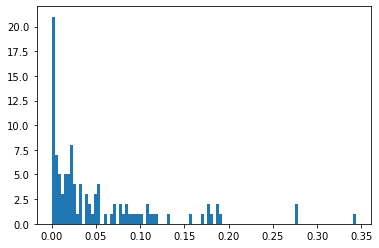

In [34]:
ogs_keep_number = 100
result_mafft_all_species_filtr = filter_ogs(result_mafft_all_species,ogs_keep_number)
msa= concatante_alignments(result_mafft_all_species_filtr,ogs_keep_number)
